In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
from itertools import count, combinations
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [3]:
LINE_STYLES =['-',  ':', '-.', (0, (3, 1, 1, 1, 1, 1)), '--']

# Load data

<div class="alert alert-warning">
<b>Warning:</b> Update the data directory path before running.
</div>

In [5]:
data_directory = "../../../../../../data/web_routineness_release_clean/"

In [6]:
USERS = pd.read_csv(data_directory + '/raw/users.csv').rename(columns={'panelist_id': 'user'})

In [7]:
SELECTED_USER_IDS = pd.read_csv(data_directory + '/pre_processed/selected_users.csv')

Here we focus on the stationary trajectory:

In [8]:
STAT_RES = pd.read_csv(data_directory + '/computation_output/stationary_trajectory/predictability.csv')
STAT_RES = SELECTED_USER_IDS.merge(STAT_RES, on='user')

Matching demographics and predictability:

In [9]:
RESULT = STAT_RES.merge(USERS[['user', 'gender', 'age_recode']], on='user')

# Predictability and demographics

### Gender

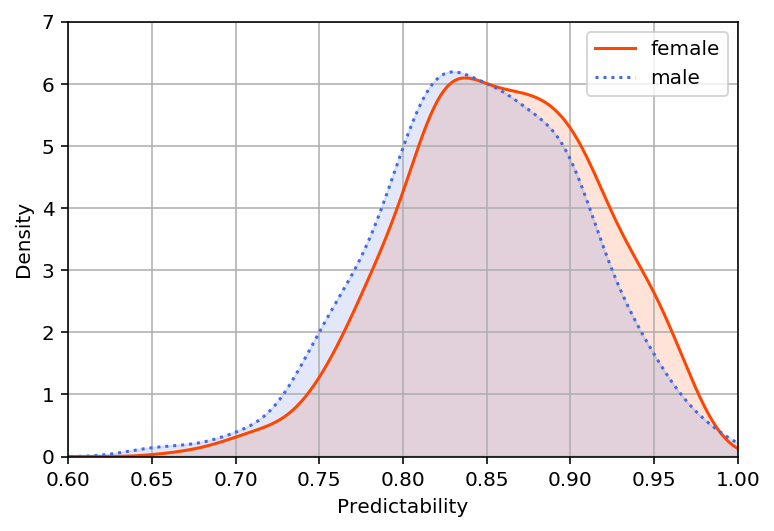

In [10]:
ARGS = dict( grid=True, xlim=(0.6, 1), ylim=(0, 7),)

VALS = ['female', 'male']

TYPE = 'Predictability'
ATTRIBUTE = 'gender'
AX_COLORS = ['orangered', 'royalblue']
fig, ax = plt.subplots(1, 1)

for val, color in zip(VALS, AX_COLORS):
    RESULT.query(f"{ATTRIBUTE} == '{val}'")[['domain_pi_max']] \
        .plot.kde(ax=ax, color=color, **ARGS)

maxes=[]
styles = LINE_STYLES[:len(ax.get_lines())]

for line, style, color in zip(ax.get_lines(), styles, AX_COLORS):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=color, alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])

ax.legend(VALS)
ax.set_xlabel('Predictability');

### Age

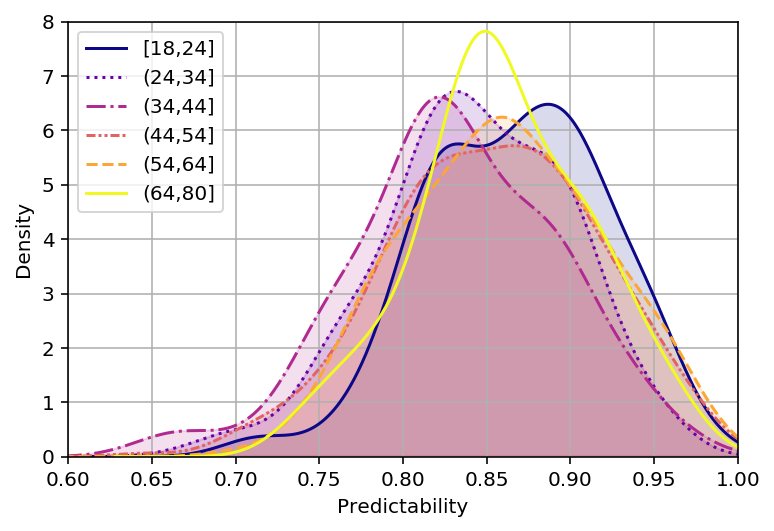

In [11]:
ARGS = dict(grid=True, xlim=(0.6, 1), ylim=(0, 8), )

VALS = ['[18,24]', '(24,34]', '(34,44]', '(44,54]', '(54,64]', '(64,80]'] # list(filter(lambda x: not pd.isnull(x), users.age_recode.unique().tolist()))

TYPE = 'Predictability'
ATTRIBUTE = 'age_recode'
AX_COLORS = plt.cm.get_cmap('plasma', len(VALS))
fig, ax = plt.subplots(1, 1)

for i, val in zip(count(), VALS):
    RESULT.query(f"{ATTRIBUTE} == '{val}'")[['domain_pi_max']] \
        .plot.kde(ax=ax, color=AX_COLORS(i), **ARGS)

maxes=[]
styles = LINE_STYLES[:len(ax.get_lines())]

for i, line, style in zip(count(), ax.get_lines(), styles):
    line.set_linestyle(style)
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=AX_COLORS(i), alpha=0.15)
    maxes.append(x[np.where(y == max(y))][0])

ax.legend(VALS)
ax.set_xlabel('Predictability');

# KS-Test & Cliff's delta

In [12]:
def apply_ks_test(DF, attribute, feature, metric, exclude_attr_vars=[]):
    
    ATTR    = attribute
    FEATURE = feature
    METRIC  = metric

    ATTR_VALS = set(DF[ATTR].dropna().unique().tolist()).difference(set(exclude_attr_vars))
    results = []

    for VAR_1, VAR_2 in combinations(ATTR_VALS, 2):
        temp = ks_2samp(
            DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_1)][f'{FEATURE}_{METRIC}'],
            DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_2)][f'{FEATURE}_{METRIC}']
        )
        results.append(
            (ATTR, FEATURE, METRIC, VAR_1, VAR_2, temp.statistic, temp.pvalue)
        )

    return pd.DataFrame(results, columns=['attribute', 'feature', 'metric', 'var_1', 'var_2', 'ks_statistic', 'p_value'])
    
    
def apply_cliffs_d(DF, attribute, feature, metric, exclude_attr_vars=[]):
    
    ATTR = attribute
    FEATURE = feature
    METRIC = metric

    ATTR_VALS = set(DF[ATTR].dropna().unique().tolist()).difference(set(exclude_attr_vars))
    results = []

    for VAR_1, VAR_2 in combinations(ATTR_VALS, 2):
        arr_1 = DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_1)][f'{FEATURE}_{METRIC}'].tolist()
        arr_2 = DF[(DF[ATTR].notnull()) & (DF[ATTR] == VAR_2)][f'{FEATURE}_{METRIC}'].tolist()
        gt, lt = 0, 0
        for a1 in arr_1:
            for a2 in arr_2:
                if a1 > a2: gt += 1
                if a1 < a2: lt += 1
        results.append(
            (ATTR, FEATURE, METRIC, VAR_1, VAR_2, (lt-gt)/(len(arr_1) * len(arr_2)))
        )
    
    return pd.DataFrame(results, columns=['attribute', 'feature', 'metric', 'var_1', 'var_2', 'cliffs_d'])

### Gender

In [13]:
apply_ks_test(RESULT, 'gender', 'domain', 'pi_max').merge(
    apply_cliffs_d(RESULT, 'gender', 'domain', 'pi_max'),
    on=['attribute', 'feature', 'metric', 'var_1', 'var_2'])

,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,gender,domain,pi_max,female,male,0.086574,0.008011,-0.114476


### Age

In [14]:
apply_ks_test(RESULT, 'age_recode', 'domain', 'pi_max').merge(
    apply_cliffs_d(RESULT, 'age_recode', 'domain', 'pi_max'),
    on=['attribute', 'feature', 'metric', 'var_1', 'var_2'])

,attribute,feature,metric,var_1,var_2,ks_statistic,p_value,cliffs_d
0,age_recode,domain,pi_max,"(24,34]","[18,24]",0.194338,0.000831,0.240561
1,age_recode,domain,pi_max,"(24,34]","(64,80]",0.200749,0.019444,0.166078
2,age_recode,domain,pi_max,"(24,34]","(54,64]",0.129823,0.011103,0.150039
3,age_recode,domain,pi_max,"(24,34]","(44,54]",0.091335,0.148183,0.095920
4,age_recode,domain,pi_max,"(24,34]","(34,44]",0.125784,0.036229,-0.117532
5,age_recode,domain,pi_max,"[18,24]","(64,80]",0.142857,0.251991,-0.083762
6,age_recode,domain,pi_max,"[18,24]","(54,64]",0.098555,0.223542,-0.083287
7,age_recode,domain,pi_max,"[18,24]","(44,54]",0.133845,0.033997,-0.132140
8,age_recode,domain,pi_max,"[18,24]","(34,44]",0.267081,0.000002,-0.341669
9,age_recode,domain,pi_max,"(64,80]","(54,64]",0.108357,0.478227,0.001153
